In [ ]:
# Implementation of a NN following the article:
# https://towardsdatascience.com/coding-a-neural-network-from-scratch-in-numpy-31f04e4d605

# Additional information taken from:
# https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
# https://mlfromscratch.com/neural-network-tutorial/#/
# https://www.youtube.com/watch?v=NJvojeoTnNM

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
# import matplotlib.pyplot as plt
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Load dataset
mnist = fetch_openml('mnist_784', cache=False)
X = mnist.data.astype('float32')
y = mnist.target.astype('int8')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# from sklearn import datasets
# iris = datasets.load_iris()
# X = iris.data.astype('float32')
# y = iris.target.astype('int64')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train = np.array(X_train).reshape((-1,28,28))
X_test = np.array(X_test).reshape((-1,28,28))
y_train = np.array(y_train).reshape((52500,))
y_test = np.array(y_test).reshape((17500,))

(52500, 28, 28)
3
(52500,)
[3 2 8 ... 1 0 0]


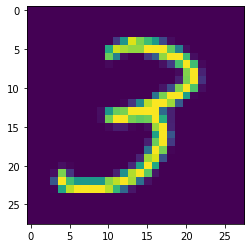

In [ ]:
print(X_train.shape)
imshow(X_train[0])
print(y_train[0])
print(y_train.shape)
print(y_train)

# Theory and Notation
- X = Inputs
- y = labels
- b = bias
- W = weights
- A = preactivation (W.T*X + b)
- H = activation g(a(x)) 

  $ H = g(A) = g(X\cdot W+b)$ 
  
  - $a^{(1)} = W^{(1)}x + b^{(1)}$ →→→ $h^{(1)} = g(a^{(1)})$
  - $a^{(2)} = W^{(2)}h^{(1)} + b^{(2)}$ →→→ $h^{(L)} = g(a^{(L)})$
  - $a^{(L+1)} = W^{(L+1)}h^{(L)} + b^{(L+1)}$

In [ ]:
# Layer Class
class Layer:
  def __init__(self, neurons):
    self.neurons = neurons

  def ReLU(self, x):
    return np.maximum(0,x)

  def Softmax(self, x):
    # Softmax(x_m) =  exp(x_m) / sum_i(exp(x_i))

    # "Standard" inputs can give inestability since exp(n) can easily overflow
    # and log(0) can happen. In case itputs are not normalized (for example
    # between 0 and 1) the following trick can be used to give it stability
    # 
    # exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
    # probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    exp_scores = np.exp(x)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    return probs
  
  def dReLU(self, dH, A):
    # ReLu derivative can be seen as:
    # ReLU is computed for a layer L as ReLU(A_L) = H_L 
    # so when the update of weights (W) or biases (b) is needed (A including both),
    # the derivative of A is needed for updating A (W and b)
    # dL/dA = dL/dH * dH/dA = dL/dReLU(A) * dReLU(A)/dA

    ## Should it be the same as copyind A instead of dH???? I think so
    dA = np.array(dH, copy = True)
    dA[A <= 0] = 0
    return dA
  
  def Forward(self, x, W, b, activation):
    # Forward pass is basically computing H, A = X*W^T + B
    # and finally H = Activation Function (A), 
    A_curr = np.dot(x, W.T) + b

    #Check if this is the same:
    # A_curr = np.dot(W, x) + b

    if activation == 'ReLU':
      H_curr = self.ReLU(A_curr)
    elif activation == 'Softmax':
      H_curr = self.Softmax(A_curr)

    return H_curr, A_curr


  ## NOTATION WARNING ###########################################
  ## dV => dC/dV, I dont have the partial derivative symbol and #
  ## dV means the "gradient of C in respect to V"               #
  ###############################################################
  def Backwards(self, dH_curr, W_curr, A_curr, H_prev, activation):
    # For the backwards pass we need to compute the gradients of all
    # the paramters: weights(dW), biases (db) and the neuron inputs
    # x (dH)
    # This is used for updating the params: ex: W_1 = W_1 - lr*dC/dW_1

    if activation == 'ReLU':
      # dC/dW =dC/dH * dH/dA * dA/dW, since dC/dA = dC/dH * dH/dA
      # is computed inside the dReLU function dC/dW can be seen as
      # dC/dW = dC/dA * dA/dWm, dA/dW its just A 
      dA = self.dReLU(dH_curr, A_curr) #dA actually means dC/dA where dC is actually dH really 

      # For the second term we need to derivate dA/dW and we know 
      # for an inner layer (only pointing this out because im gonna name the)
      # inputs as H (of the prev layer) instead of x)
      # A = W*H + B, dA/dW = H 
      dW = np.dot(H_prev.T, dA)

      # For dC/db we just have to take dA into account since
      # dA/db = 1
      db = np.sum(dA, axis=0, keepdims=True)

      # For dC/dH its the same except now we need dA/dH = W
      dH = np.dot(dA, W_curr)

    elif activation == 'Softmax':
      # Softmax function is defined for x_m as
      # Softmax(x_m) = exp(x_m)/sum(exp(x_i)), so when obtaining the gradients
      # for each parameter we need to derivate respect the specific param.
      # changing notation to x => H for inner layer we can say the output of the softmax
      # layer is H_curr = exp(h_prev)/sum(exp(sum(h_n))), so without taking into account a cross entropy function:
      #
      # #REFSOFT #REFSOFT #REFSOFT *****
      # dH_curr/dW =  dH_curr/dA * dA/dW
      #   For the case where h_n = h_prev
      #   dH_curr/dA = d/dA * exp(A)/(exp(A)+exp(A_n)) = (exp(A)*(exp(A)+exp(A_n))/(exp(A)+exp(A_n))^2 - (exp(A)^2)/(exp(A)+exp(A_n))^2
      #              = exp(A)/(exp(A)+exp(A_n)) - (exp(A)/(exp(A)+exp(A_m)))^2 
      #              = dH_curr - dH_curr^2 = dH_curr(1-dH_curr)
      #   For the rest
      #   dH_curr/da = -dH_curr*dH_n_curr
      #  dA/dW = d/dW (H_prev*W+b) = H_prev
      # https://stats.stackexchange.com/questions/235528/backpropagation-with-softmax-cross-entropy

      # dH_curr in this case is computed outside and refers to dH_curr/dA (i think) #REFSOFT #REFSOFT #REFSOFT
      # >> Softmax derivative can be [ exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0)) ]
      dW = np.dot(H_prev.T, dH_curr)

      # For dH_curr/db, it will be the same except dA/db = 1 so 
      db = np.sum(dH_curr, axis=0, keepdims=True)

      # For dH_curr/dH(_prev) = dH_curr/dA * dA/dH = dH_curr * W_curr
      dH = np.dot(dH_curr, W_curr)

    return dH, dW, db

In [ ]:
#Metwork Class
class Network:
  def __init__(self):
    self.network = []      # Layers
    self.architecture = [] # Mapping input to output neurons
    self.params = []       # W, b
    self.memory = []       # H, A
    self.gradients = []    # dW, db

  def add(self, layer):
    # Adds a layer to the network array
    self.network.append(layer)

  def _compile(self, data):
    # Iterates through the neurons array in order to set up the layers mapping
    # The mapping is done taking the ouput dimension of the previous layer
    # to inputting it to the next layer (output number) and configuring
    # the activation function used in the neurons of the layer
    for idx, layer in enumerate(self.network):
      if idx == 0:
        self.architecture.append({'input_dim':  data.shape[1],
                                  'output_dim': self.network[idx].neurons,
                                  'activation': 'ReLU'})
      elif idx > 0 and idx < len(self.network)-1:
        self.architecture.append({'input_dim':  self.network[idx-1].neurons,
                                  'output_dim': self.network[idx].neurons,
                                  'activation': 'ReLU'})
      else:
        self.architecture.append({'input_dim':  self.network[idx-1].neurons,
                                  'output_dim': self.network[idx].neurons,
                                  'activation': 'Softmax'})
    return self

  def _init_weights(self, data):
    self._compile(data)

    np.random.seed(99)

    for i in range(len(self.architecture)):
      self.params.append({'W':np.random.uniform(low=-1, high=1, size=(self.architecture[i]['output_dim'], self.architecture[i]['input_dim'])),
                          'b':np.zeros((1, self.architecture[i]['output_dim']))})
      
    return self

  def _forwardprop(self, data):
    H_curr = data

    # print(data)

    for i in range(len(self.params)):
      H_prev = H_curr 
      H_curr, A_curr = self.network[i].Forward(x=H_prev, W=self.params[i]['W'], b=self.params[i]['b'], activation=self.architecture[i]['activation'])
      self.memory.append({'H': H_prev, 'A': A_curr})  
    #Returns neuron output
    return H_curr 

  def _backprop(self, predicted, actual):
    num_samples = len(actual)

    # In order to get the needed gradient (the one that is passed to the backwards prop
    # function as dH_curr) we need to use the predicted (last layer output) 
    # dL/dH = d
    
    # This is the derivation for backpropagation from the sofmax layer, its
    # only computed once since the softmax activation function is only usyed
    # for the final layer, then its passed only once to the for loop below
    # (backpropagation loop) since for the next steps dH_prev is updated 
    # and stops being the original (the one from the softmax) gradient

    # The derivation is done with the kronken delta "trick", when derivating 
    # the softmax function in respect to its input (preactivation of the layer, A),
    # we obtain what shown on #REFSOFT (search avobe):
    # dSoftmax(A_i)/dA = d/dA_j * (exp(A_i)/sum(exp(A)))
    #   for i = j
    #     d/dA_j = exp(A_i)/(sum(exp(A)))(1-exp(A_j)/(sum(exp(A)))))
    #   for i != j
    #     d/dA_j = - exp(A_i)/sum(exp(A)) * exp(A_j)/sum(exp(A))
    #            =   exp(A_i)/sum(exp(A))(0 - exp(A_j)/sum(exp(A)))
    #
    # When apllying the "delta trick" we just describe the fact that
    # for i=j we have "1" inside the parenthesis and for i!=j a "0"´
    # as the konken delta is 1 when evaluated in 0 and 0 elsewhere
    # 
    # In this case the gradient is being calculated taking into account 
    # that the loss function used is the Cross-Entropy, so we can particularize
    # the formula. 
    # 
    # dL/dA = dL/dH * dH/dA = dL/dSoftmax * dSoftmax/dA = dL/dYpred * dYpred/dA
    #   dL/dYpred = - sum(y_ij/ypred_ij) because of the logarithmic form of the cross entropy (L)
    # dL/dA = - sum(y_ij/ypred_ij) * dYpred/dA =   sum(y_ij/ypred_ij) * dSoftmax/dA
    #   We knwor from the previous deduction (#REFSOFT) dSoftmax/dA 

    dscores = predicted
    dscores[range(num_samples),actual] -= 1
    dscores /= num_samples
    
    # So apparently this is WRONG since for this "backwards pass" to work 
    # (calculating the gradients of the ouptuts in this way) we need to recieve 
    # a value procedent form a forward pass which has the categorical Cross-Entropy
    # as las step since this derivative is specific for that case
    # One-Hot encoding is not needed (nor expected) for "actual" or y_true 
  
    #exps = np.exp(predicted - predicted.max())
    #dscores = exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))

    dH_prev = dscores

    for idx, layer in reversed(list(enumerate(self.network))):
        dH_curr = dH_prev

        H_prev = self.memory[idx]['H']
        A_curr = self.memory[idx]['A']
        W_curr = self.params[idx]['W']
        activation = self.architecture[idx]['activation']

        dH_prev, dW_curr, db_curr = layer.Backwards(dH_curr, W_curr, A_curr, H_prev, activation)

        self.gradients.append({'dW':dW_curr, 'db':db_curr})
        
  def _update(self, lr=0.01):
    
    for idx, layer in enumerate(self.network):
      self.params[idx]['W'] -= lr * list(reversed(self.gradients))[idx]['dW'].T  
      self.params[idx]['b'] -= lr * list(reversed(self.gradients))[idx]['db']

  def _get_accuracy(self, predicted, actual):
    return np.mean(np.argmax(predicted, axis=1)==actual)

  def _calculate_loss(self, predicted, actual):
    samples = len(actual)

    # Clipping helps with stability for cases like log(0)
    predicted_clipped = np.clip(predicted, 1e-7, 1-1e-7)

    correct_logprobs = -np.log(predicted_clipped[range(samples),actual])
    data_loss = np.sum(correct_logprobs)/samples

    return data_loss
  
  def train(self, X_train, y_train, epochs):
    #SDG
    self.loss = []
    self.accuracy = []

    self._init_weights(X_train)

    for i in range(epochs):
      yhat = self._forwardprop(X_train)
      # print("yhat")
      # print(yhat)
      self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_train))
      self.loss.append(self._calculate_loss(predicted=yhat, actual=y_train))

      self._backprop(predicted=yhat, actual=y_train)

      self._update()

      if i % 20 == 0:
        s = 'EPOCH: {}, ACCURACY: {}, LOSS: {}'.format(i, self.accuracy[-1], self.loss[-1])
        print(s)

In [ ]:
model = Network();
model.add(Layer(128))
model.add(Layer(10))

# def one_hot(y, num):
#   oh = np.zeros((y.shape[0],num)).astype(np.int8)
#   for i, j in enumerate(y):
#     oh[i][j] = 1
#   return oh

#y = LabelEncoder().fit_transform(y_train)
# y_train_oh = one_hot(y_train, 10)

model.train(X_train.reshape((-1,28*28))/255, y_train, 200)


EPOCH: 0, ACCURACY: 0.09706666666666666, LOSS: 13.33863014094879


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


EPOCH: 20, ACCURACY: 0.09883809523809524, LOSS: nan
EPOCH: 40, ACCURACY: 0.09883809523809524, LOSS: nan
EPOCH: 60, ACCURACY: 0.09883809523809524, LOSS: nan
EPOCH: 80, ACCURACY: 0.09883809523809524, LOSS: nan
